Research Question 1
Distinct timezones for each repository and their correlation with time-to-merge.

For each repositoy, we retrieved the location of all collaborators. In a json file, we placed all collaborators that have their location on their GitHub profile, removing all collaborators that have 'Null' values as their locations. Furthermore, we computed the average time-to-merge for all pull requests in the respective repository. 

In [ ]:
import json
from datetime import datetime

def time_difference(d1, d2, unit='hours'):
    d1 = datetime.strptime(d1, '%Y-%m-%dT%H:%M:%SZ')
    d2 = datetime.strptime(d2, '%Y-%m-%dT%H:%M:%SZ')
    
    time_diff = d2 - d1
    
    if unit == 'hours':
        return time_diff.total_seconds() / 3600
    elif unit == 'minutes':
        return time_diff.total_seconds() / 60
    else:
        raise ValueError("Invalid unit. Please use 'hours' or 'minutes'.")

f1 = open("data/4_collaborators_and_users_with_timezone.json")
f2 = open("data/4_pull_requests.json")
data_tz = json.load(f1)
data_pr = json.load(f2)

repos = []

for item in data_pr:
    #print(f"repo name of pr is {item['full_name']}")
    pull_requests = []

    for entry in item['pull_requests']:
        if (entry['created_at'] and entry['merged_at']) is not None:
            pull_requests.append(time_difference(entry['created_at'], entry['merged_at'],'hours'))
    if len(pull_requests) == 0:
        average_pull_requests = 0
    elif len(pull_requests) > 0:
        average_pull_requests = sum(pull_requests) / len(pull_requests)
    
    repos.append({
        "repo_name": item['full_name'],
        "pull_requests": pull_requests,
        "pull_request_average": average_pull_requests
    })


final_repos = []
i = 0
for item in data_tz:
    #print(f"repo name is {item['name']}")
    locations = []
    for entry in item['users_location']:
        if 'bot' not in entry['login']:
            if entry['location'] is not None:
                locations.append(entry['location'])
            elif entry['bio'] is not None:
                locations.append(entry['bio'])
                #print("biooooooooooooooooooooooooooooooooooo")
            elif entry['company'] is not None:
                #print("companyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy")
                locations.append(entry['company'])

    if len(locations) != 0:
        repo_index = next((i for i, r in enumerate(repos) if r["repo_name"] == item['name']), None)
        if repo_index is not None:
            if repos[repo_index]['pull_request_average'] != 0:
                final_repos.append({
                    "repo_name": item['name'],
                    "locations": locations,
                    "time_to_merge": repos[repo_index]['pull_requests'],
                    "time_to_merge_average": repos[repo_index]['pull_request_average']
                })
        i += 1

with open("RQ1_2_Locations_PR.json", "w") as outfile:
    json.dump(final_repos, outfile)
print("done writing to json")

From the data gathered before, we process the data so that we place each location in it's respective UTC timezone. We count how many collaborators of a repository belong to a distinct timezone. We also keep the average time-to-merge for each repositoy. After we place all this data into a json file, we will perform statistical analysis.

In [ ]:
import pytz
from datetime import datetime, timezone
from collections import defaultdict
import json

f = open("data_rq1/RQ1_2_Locations_PR.json")
location_data = json.load(f)

# Initialize the output dictionary
output_data = {}

for item in location_data:
    repo_name = item['repo_name']
    if repo_name not in output_data:
        output_data[repo_name] = {
            "average_pr_time": item['time_to_merge_average']
        }

    timezone_counts = defaultdict(int)
    timezone_offsets = []
    for location in item['locations']:
        try:
            tz_obj = pytz.timezone(location)
            utc_offset = tz_obj.utcoffset(datetime.now())
            if utc_offset.total_seconds() == 0:
                tz_offset_str = "UTC+0"
            else:
                tz_offset_str = f"UTC{'+' if utc_offset.total_seconds() > 0 else '-'}{abs(int(utc_offset.total_seconds() / 3600))}"
            timezone_counts[tz_offset_str] += 1
            
            # Extract the numeric offset from the string
            if tz_offset_str.startswith("UTC+"):
                timezone_offsets.append(int(tz_offset_str[4:]))
            elif tz_offset_str.startswith("UTC-"):
                timezone_offsets.append(-int(tz_offset_str[4:]))
            else:
                timezone_offsets.append(0)
        except pytz.exceptions.UnknownTimeZoneError:
            print(f"Unknown timezone: {location}")

    for timezone, count in timezone_counts.items():
        output_data[repo_name][timezone] = count
    output_data[repo_name]['nr_timezones'] = len(timezone_counts)

    # Calculate the timezone difference
    min_offset = min(timezone_offsets)
    max_offset = max(timezone_offsets)
    timezone_difference = abs(max_offset - min_offset)
    output_data[repo_name]['timezone_difference'] = timezone_difference

with open("RQ1_utc_count_avg_prs.json", "w") as outfile:
    json.dump(output_data, outfile)

print("done writing to json")

Now we will sort the UTC timezones for each repository.

In [ ]:
import json

f = open("data_rq1/RQ1_utc_count_avg_prs.json")
data = json.load(f)

# Function to order the time zones
def order_timezones(data,repo_name):
    ordered_data = {}
    #add name of repository to the item
    ordered_data['repo_name'] = repo_name

    # Create lists for UTC+ and UTC- timezones
    utc_plus_timezones = []
    utc_minus_timezones = []

    # Populate the lists
    for timezone, count in data.items():
        if timezone.startswith("UTC+"):
            utc_plus_timezones.append((timezone, count))
        elif timezone.startswith("UTC-"):
            utc_minus_timezones.append((timezone, count))
        elif timezone == "average_pr_time" or timezone == "nr_timezones" or timezone == "timezone_difference":
            ordered_data[timezone] = data[timezone]

    # Order the lists
    utc_plus_timezones.sort(key=lambda x: int(x[0][4:]), reverse=False)
    utc_minus_timezones.sort(key=lambda x: int(x[0][4:]), reverse=True)

    # Merge the lists
    ordered_timezones = utc_minus_timezones + utc_plus_timezones

    # Create the final ordered data
    for timezone, count in ordered_timezones:
        ordered_data[timezone] = count

    return ordered_data


utc_list = []

for item in data:
    utc_list.append(order_timezones(data[item],item))


with open("data_rq1/RQ1_utc_ordered_avg_prs.json", "w") as outfile:
    json.dump(utc_list, outfile)
    print("written to json file")

Now we will make a histogram for all ordered timezones across all repositories.

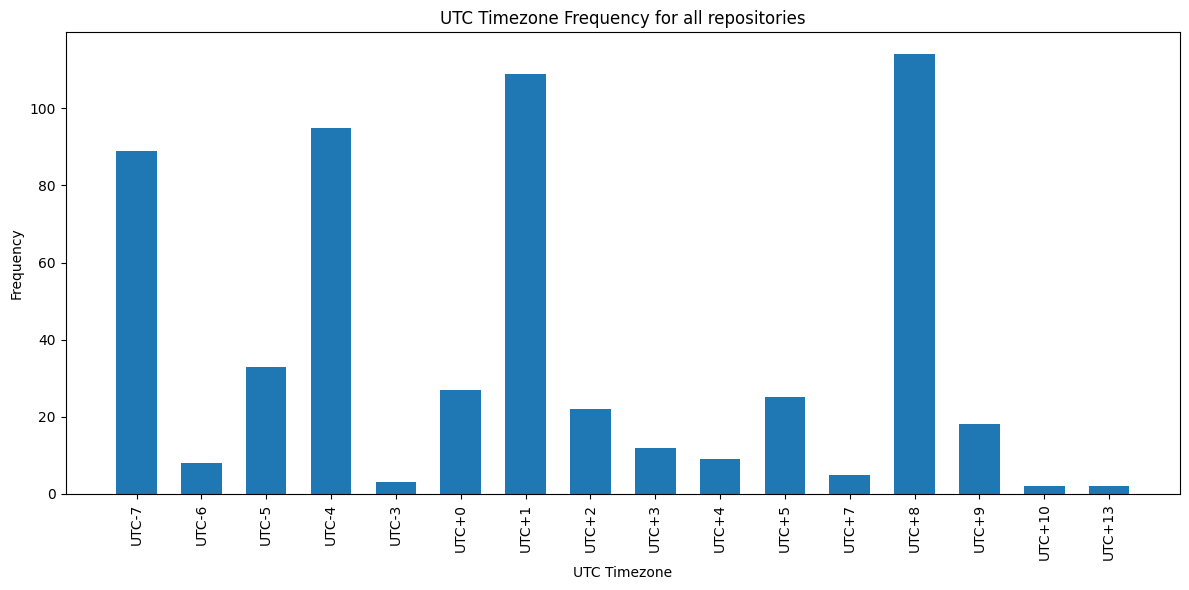

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

with open("data_rq1/RQ1_utc_ordered_avg_prs.json", "r") as f:
    data = json.load(f)

# Create a dictionary to store the frequencies
timezone_frequencies = {}

for item in data:
    for timezone, count in item.items():
        if isinstance(count, int) and timezone != "repo_name" and timezone != "average_pr_time" and timezone != "nr_timezones" and timezone != "timezone_difference":
            if timezone not in timezone_frequencies:
                timezone_frequencies[timezone] = 0
            timezone_frequencies[timezone] += count

# Separate the timezones into two lists
utc_plus_timezones = []
utc_minus_timezones = []

for timezone, count in timezone_frequencies.items():
    if timezone.startswith("UTC+"):
        utc_plus_timezones.append((timezone, count))
    elif timezone.startswith("UTC-"):
        utc_minus_timezones.append((timezone, count))

# Order the lists
utc_plus_timezones.sort(key=lambda x: int(x[0][4:]), reverse=False)
utc_minus_timezones.sort(key=lambda x: int(x[0][4:]), reverse=True)

# Merge the lists
frequency_timezones_all_repos = utc_minus_timezones + utc_plus_timezones

# Plot the histogram
plt.figure(figsize=(12, 6))
x_values = [tz[0] for tz in frequency_timezones_all_repos]
y_values = [tz[1] for tz in frequency_timezones_all_repos]
bar_width = 10 / len(frequency_timezones_all_repos)
plt.bar(x_values, y_values, width=bar_width)
plt.xticks(rotation=90)
plt.xlabel("UTC Timezone")
plt.ylabel("Frequency")
plt.title("UTC Timezone Frequency for all repositories")
plt.tight_layout()
plt.show()

to do:
1) histogram with ordered timezones for all repositories.
2) statistical analysis